# XY - Modell

In [35]:
# Standard imports for computational physics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import json
from scipy.optimize import curve_fit
import scienceplots

# Pretty styling for graphs
plt.style.use(['science', 'grid', 'scatter'])
plt.rcParams["figure.figsize"] = (12, 8)

# Select most recent run

In [36]:
con = sqlite3.connect('output.sqlite')
current_run = pd.read_sql_query('SELECT id FROM runs ORDER BY created_at DESC', con).at[0, 'id']

# Energy

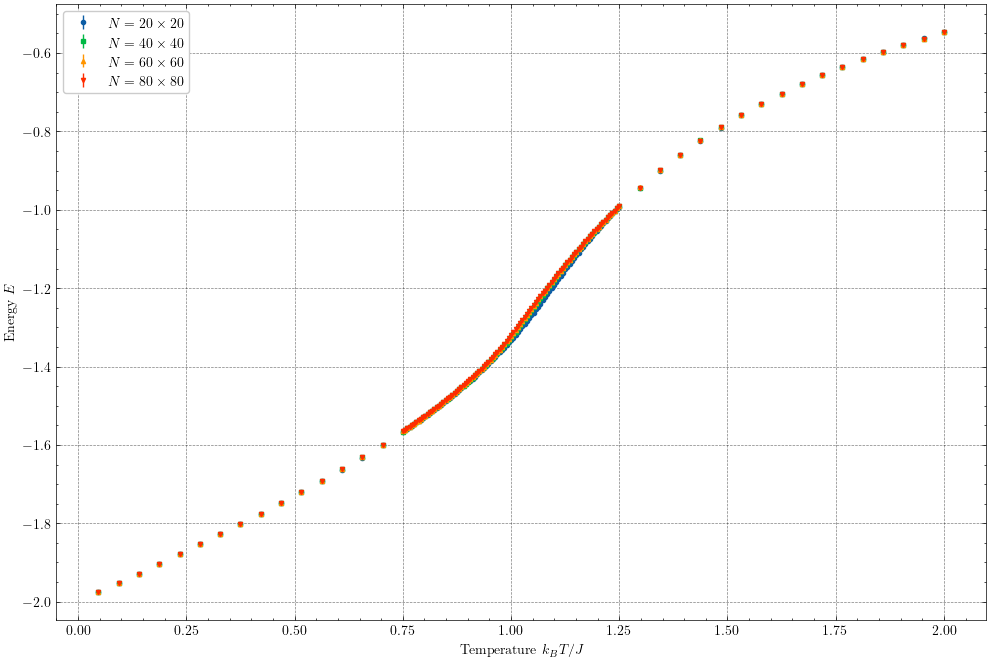

In [37]:
fig, ax = plt.subplots()
for size in pd.read_sql_query(f'SELECT size FROM configurations WHERE run_id = \'{current_run}\' AND size IN (20, 40, 60, 80) GROUP BY size', con)['size']:
    data = pd.read_sql_query(f'SELECT temperature, energy, energy_std FROM configurations WHERE run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
    ax.errorbar(data['temperature'], data['energy'], yerr=data['energy_std'], label=f'$N = {size} \\times {size}$')

ax.set_xlabel('Temperature $k_B T / J$')
ax.set_ylabel('Energy $E$')

ax.legend()
fig.savefig('figures/Energy.pdf', bbox_inches='tight')

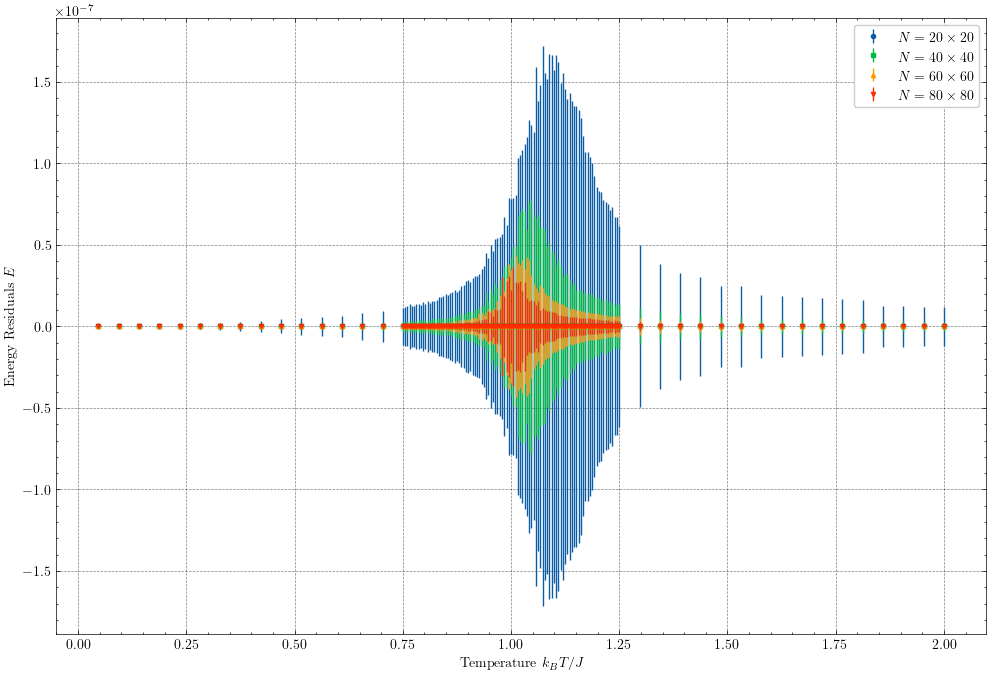

In [38]:
fig, ax = plt.subplots()
for size in pd.read_sql_query(f'SELECT size FROM configurations WHERE run_id = \'{current_run}\' AND size IN (20, 40, 60, 80) GROUP BY size', con)['size']:
    data = pd.read_sql_query(f'SELECT temperature, energy_std FROM configurations WHERE run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
    ax.errorbar(data['temperature'], [0] * len(data['energy_std']), yerr=data['energy_std'], label=f'$N = {size} \\times {size}$')

ax.set_xlabel('Temperature $k_B T / J$')
ax.set_ylabel('Energy Residuals $E$')

ax.legend()
fig.savefig('figures/Energy_Residual.pdf', bbox_inches='tight')

# Magnetisation

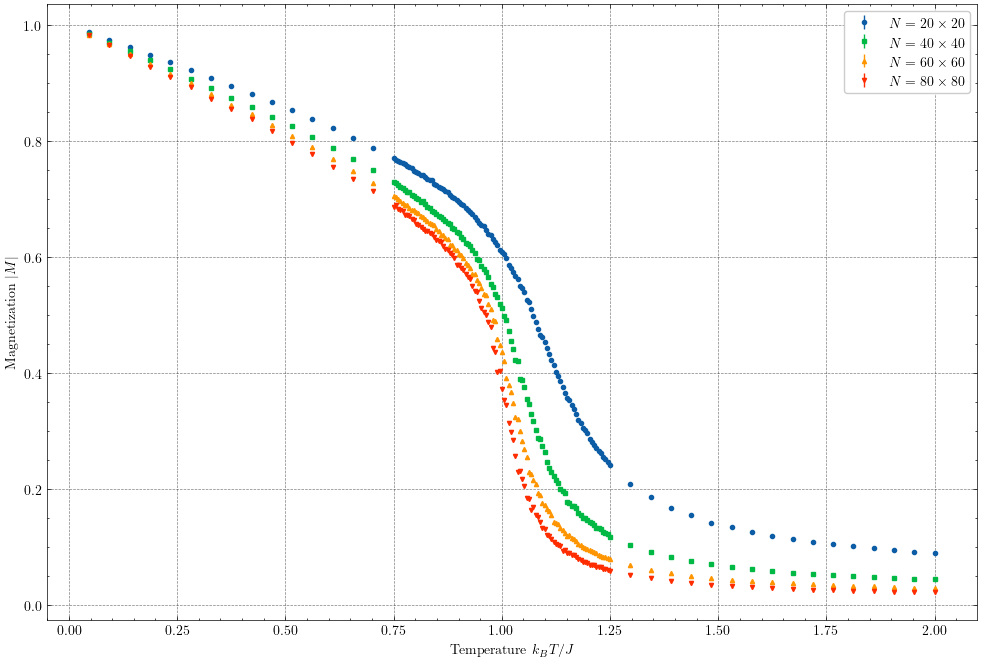

In [39]:
fig, ax = plt.subplots()
for size in pd.read_sql_query(f'SELECT size FROM configurations WHERE run_id = \'{current_run}\' AND size IN (20, 40, 60, 80) GROUP BY size', con)['size']:
    data = pd.read_sql_query(f'SELECT temperature, magnet, magnet_std FROM configurations WHERE run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
    ax.errorbar(data['temperature'], data['magnet'], yerr=data['magnet_std'], label=f'$N = {size} \\times {size}$')

ax.set_xlabel('Temperature $k_B T / J$')
ax.set_ylabel('Magnetization $\\lvert M \\rvert$')

ax.legend()
fig.savefig('figures/Magnetization.pdf', bbox_inches='tight')

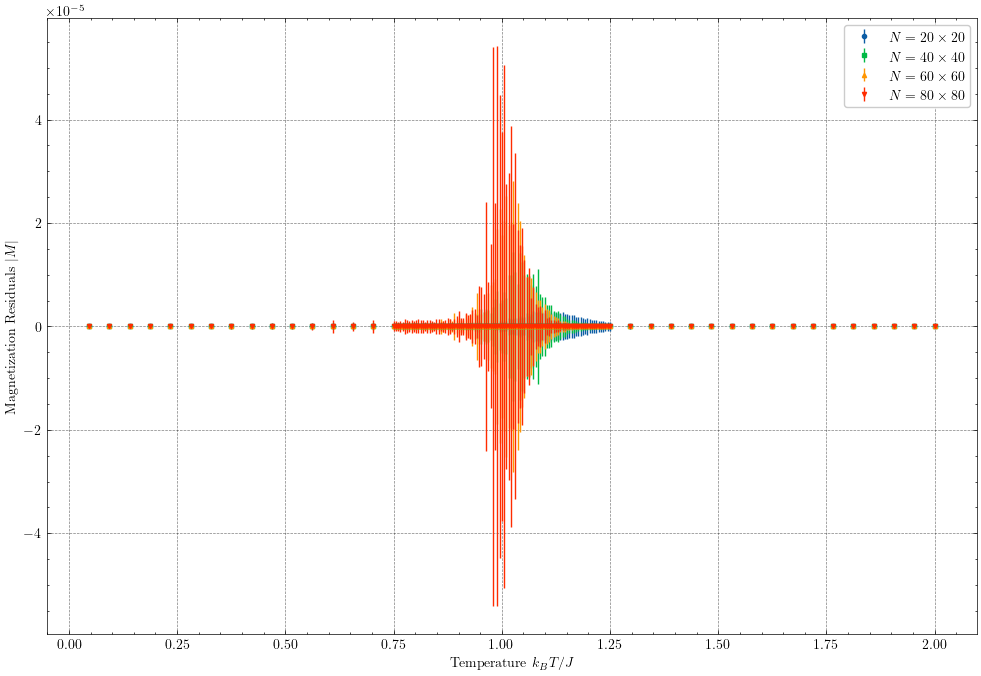

In [40]:
fig, ax = plt.subplots()
for size in pd.read_sql_query(f'SELECT size FROM configurations WHERE run_id = \'{current_run}\' AND size IN (20, 40, 60, 80) GROUP BY size', con)['size']:
    data = pd.read_sql_query(f'SELECT temperature, magnet, magnet_std FROM configurations WHERE run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
    ax.errorbar(data['temperature'], [0] * len(data['magnet_std']), yerr=data['magnet_std'], label=f'$N = {size} \\times {size}$')

ax.set_xlabel('Temperature $k_B T / J$')
ax.set_ylabel('Magnetization Residuals $\\lvert M \\rvert$')

ax.legend()
fig.savefig('figures/Magnetization_Residuals.pdf', bbox_inches='tight')

# Specific Heat

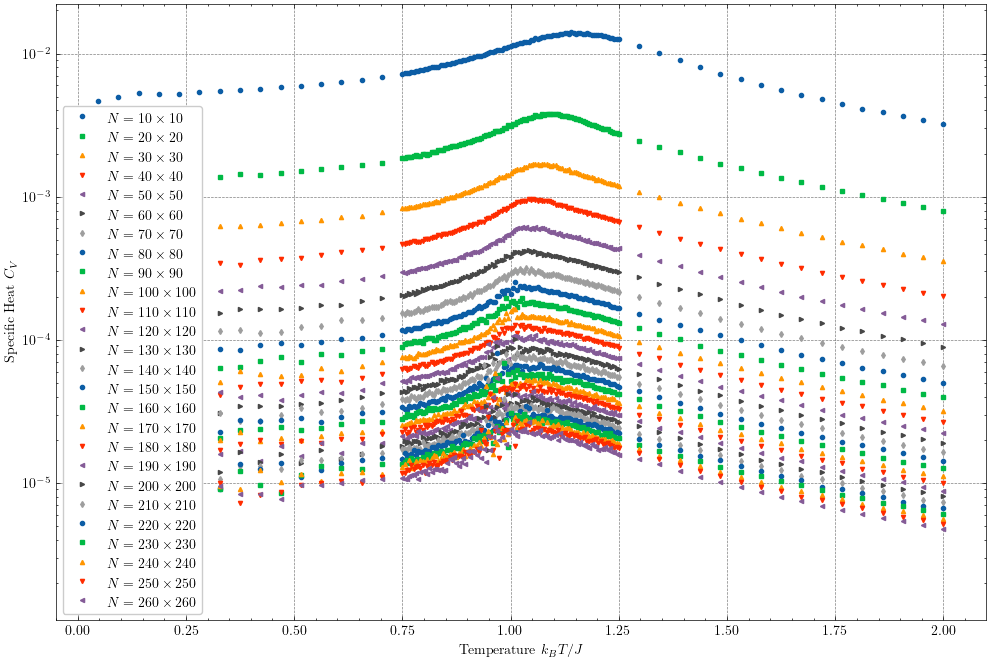

In [41]:
fig, ax = plt.subplots()
for size in pd.read_sql_query(f'SELECT size FROM configurations WHERE run_id = \'{current_run}\' GROUP BY size', con)['size']:
    data = pd.read_sql_query(f'SELECT temperature, specific_heat FROM configurations WHERE run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
    ax.errorbar(data['temperature'], data['specific_heat'], label=f'$N = {size} \\times {size}$')

ax.set_xlabel('Temperature $k_B T / J$')
ax.set_ylabel('Specific Heat $C_V$')

ax.set_yscale('log')
ax.legend()
fig.savefig('figures/Specific_Heat.pdf', bbox_inches='tight')

# Magnetic susceptibility

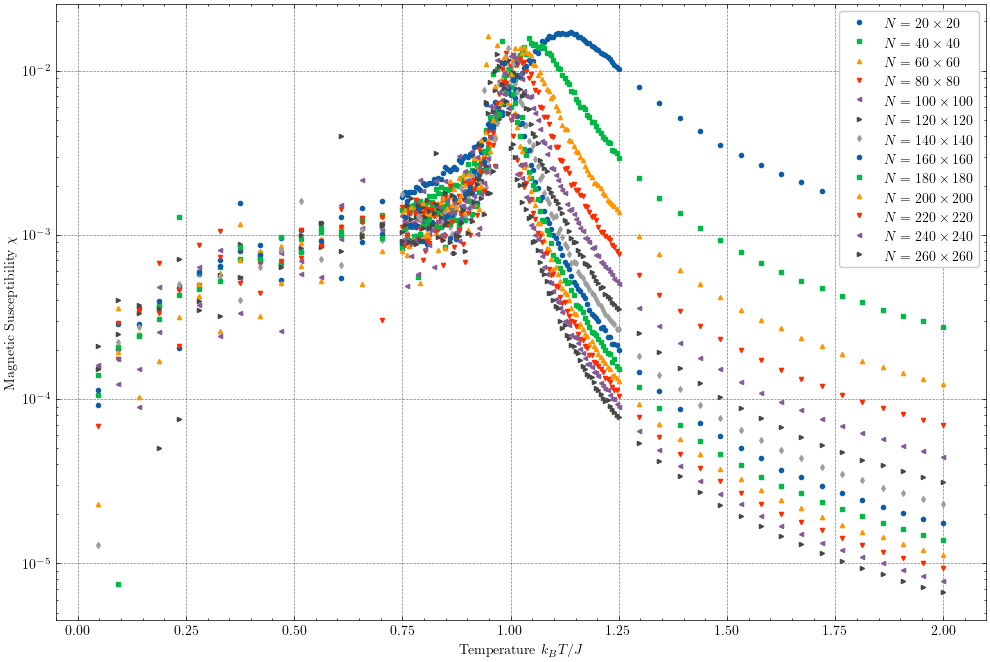

In [42]:
sizes = []
maximas = []
delta_maximas = []

fig, ax = plt.subplots()
for size in pd.read_sql_query(f'SELECT size FROM configurations WHERE run_id = \'{current_run}\' AND size % 20 = 0 GROUP BY size', con)['size']:
    data = pd.read_sql_query(f'SELECT temperature, magnet_suscept, energy FROM configurations WHERE run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
    ax.errorbar(data['temperature'], data['magnet_suscept'], label=f'$N = {size} \\times {size}$')

    max_idx = data['magnet_suscept'].idxmax()
    max_temp = data.loc[max_idx]['temperature']
    delta_max_temp = np.abs(data.loc[max_idx]['temperature'] - data.loc[max_idx + 1]['temperature'])

    sizes.append(1.0 / np.log(size)**2)
    maximas.append(max_temp)
    delta_maximas.append(delta_max_temp)

ax.set_xlabel('Temperature $k_B T / J$')
ax.set_ylabel('Magnetic Susceptibility $\\chi$')

ax.set_yscale('log')
ax.legend()
fig.savefig('figures/Magnetic_Susceptibility.pdf', bbox_inches='tight')

[2.14389949 0.8960709 ]
[0.06792806 0.00364239]
R Squared: 0.94798847


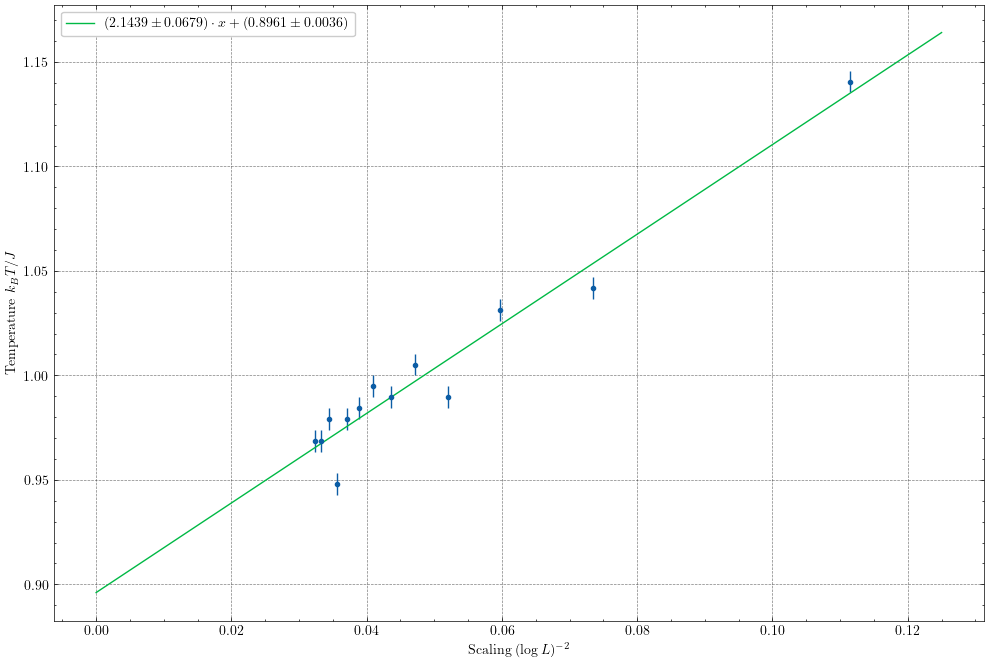

In [43]:
sizes = np.array(sizes)
maximas = np.array(maximas)
delta_maximas = np.array(delta_maximas)

fig, ax = plt.subplots()
ax.errorbar(sizes, maximas, yerr=delta_maximas)

def linear_fn(x: float, slope: float, intercept: float) -> float:
    return slope * x + intercept

popt, pcov = curve_fit(linear_fn, sizes, maximas, sigma=delta_maximas, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
print(popt)
print(perr)

residuals = maximas - linear_fn(sizes, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((maximas - np.mean(maximas))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f'R Squared: {r_squared:.8f}')

sampling = np.linspace(0, 0.125, num=100)
ax.plot(sampling, linear_fn(sampling, *popt), '-', label=f'$({popt[0]:.4f} \\pm {perr[0]:.4f}) \\cdot x + ({popt[1]:.4f} \\pm {perr[1]:.4f})$')

ax.set_xlabel('Scaling $(\\log{L})^{-2}$')
ax.set_ylabel('Temperature $k_B T / J$')

ax.legend()
fig.savefig('figures/Critical_Temperature.pdf', bbox_inches='tight')

# Vortex unbinding

In [44]:
size = 80

data = pd.read_sql_query(f'SELECT temperature, spins FROM configurations WHERE run_id = \'{current_run}\' AND size = {size} ORDER BY temperature', con)
data = data[data.index % 8 == 0]

data['spins'] = data['spins'].apply(lambda x: np.array(json.loads(x)))
data['u'] = data['spins'].transform(lambda x: np.reshape(np.cos(x), (-1, size)))
data['v'] = data['spins'].transform(lambda x: np.reshape(np.sin(x), (-1, size)))

x = np.arange(1, size + 1, 1)
y = np.arange(1, size + 1, 1)

X, Y = np.meshgrid(x, y)

for idx, row in data.iterrows():
    fig, ax = plt.subplots()
    ax.set_box_aspect(1)

    ax.quiver(X, Y, row['u'], row['v'], row['spins'], scale=40, pivot='middle', cmap='hsv')
    ax.set_title(f'Temperature $T={row['temperature']:.3f}$')

    temperature = f'{row['temperature']:.3f}'.replace(".", "_")
    fig.savefig(f'figures/vortices/{temperature}.png', dpi=300, bbox_inches='tight')
    plt.close(fig)

# Critical Slowing Down

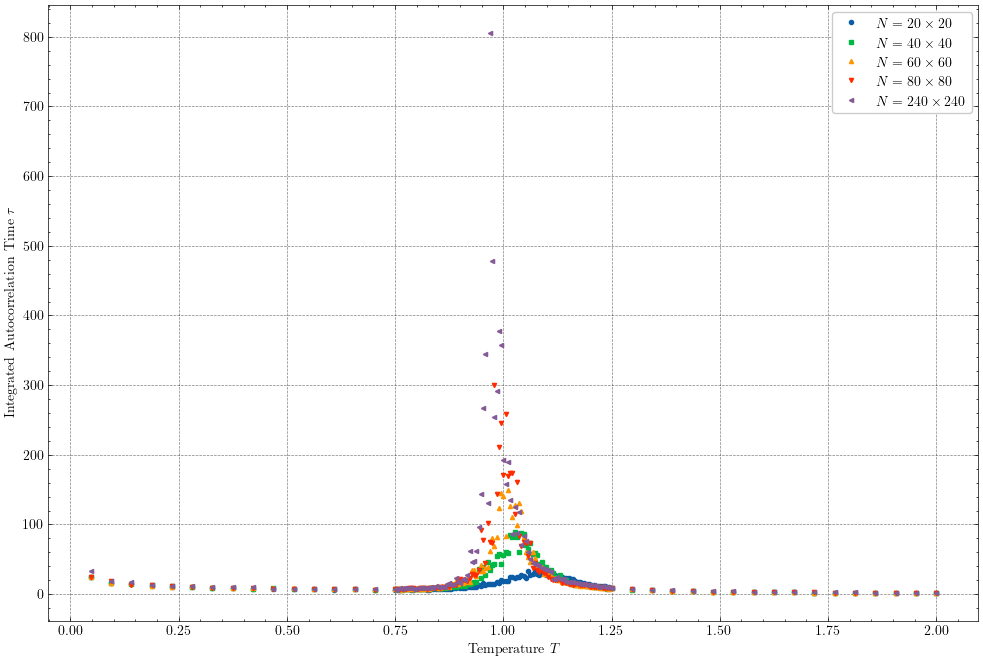

In [45]:
fig, ax = plt.subplots()
for size in pd.read_sql_query(f'SELECT size FROM configurations WHERE run_id = \'{current_run}\' AND size IN (20, 40, 60, 80, 240) GROUP BY size', con)['size']:
    data = pd.read_sql_query(f'SELECT temperature, energy_tau FROM configurations WHERE run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
    ax.errorbar(data['temperature'], data['energy_tau'], label=f'$N = {size} \\times {size}$')

ax.set_xlabel('Temperature $T$')
ax.set_ylabel('Integrated Autocorrelation Time $\\tau$')

ax.legend()
fig.savefig('figures/Critical_Slowing_Down.pdf', bbox_inches='tight')

# Scaling

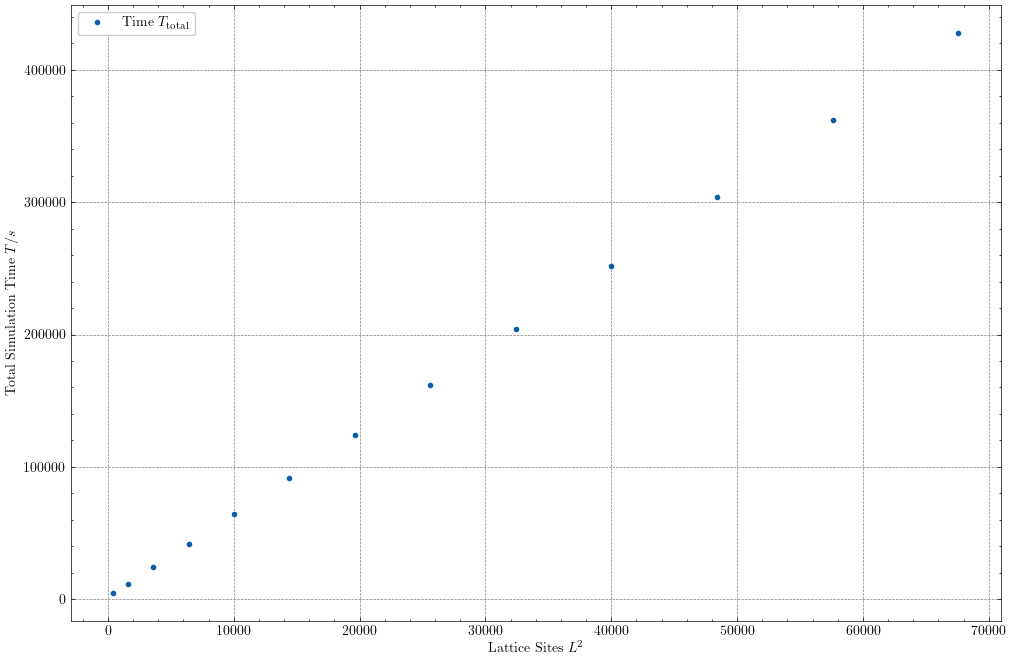

In [46]:
fig, ax = plt.subplots()

data = pd.read_sql_query(f'SELECT size, SUM(duration) AS total FROM configurations WHERE run_id = \'{current_run}\' AND size % 20 = 0 GROUP BY size', con)
ax.errorbar(data['size']**2, data['total'] / 1000, label='Time $T_\\text{total}$')

ax.set_xlabel('Lattice Sites $L^2$')
ax.set_ylabel('Total Simulation Time $T / s$')

ax.legend()
fig.savefig('figures/Time_Scaling.pdf', bbox_inches='tight')